In [1]:
import time
import sys
sys.path.append(r"/home/jiomer/Documents/pygdsm/pygdsm")
sys.path.append(r"/home/jiomer/Documents/pygdsm/DEoRtool")

from MTRT import *
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from LGSM import LGSM
from datetime import datetime
from DEORtool import DEOR_tool
from DEORtool import EoRmod
from DEORtool import DEOR_simulation
from cbeam import cbeam

from IPython.display import Latex

In [2]:
# 设置流星参数
mt_theta = 45
mt_phi = 300
# 距离坐标单位为km
mt_origin = [55,75,100]
mt = MeteorTrail(mt_origin,mt_theta,mt_phi,length=80)
Mm = mt.get_zvector()
#print(Mm)
wl_origin = mt.trans_origin()
#print(wl_origin)
Mt_position = mt.end
Mt_RP = (np.array(mt_origin)+Mt_position)/2
#print("Meteor cenetr to origin: ",Mt_RP)
# 流星中点到原点的距离，用于计算功率
Mt_R = np.dot(Mt_RP,Mt_RP)**0.5*1000
#print(Mt_R)
#print(Mt_position)
# 得到local坐标系的基
localx,localy,localz = getwl(Mm,mt_origin)
#print(localx,localy,localz)

mtheta,mphi = MTvec2ang(mt_origin[0],mt_origin[1],mt_origin[2])
print("Meteor start point coords: ",mtheta*180/np.pi,mphi*180/np.pi)
Mtheta,Mphi = MTvec2ang(Mt_position[0],Mt_position[1],Mt_position[2])
print("Meteor end point coords: ",Mtheta*180/np.pi,Mphi*180/np.pi)

# m是流星原点，M是流星终点
# mx，my是流星原点在天球圆投影坐标， Mx，My同理
mx = np.sin(mtheta)*np.cos(mphi)
Mx = np.sin(Mtheta)*np.cos(Mphi)

my = np.sin(mtheta)*np.sin(mphi)
My = np.sin(Mtheta)*np.sin(Mphi)

Meteor start point coords:  42.924476930175054 53.74616226255522
Meteor end point coords:  29.12972761551238 17.34391486384791


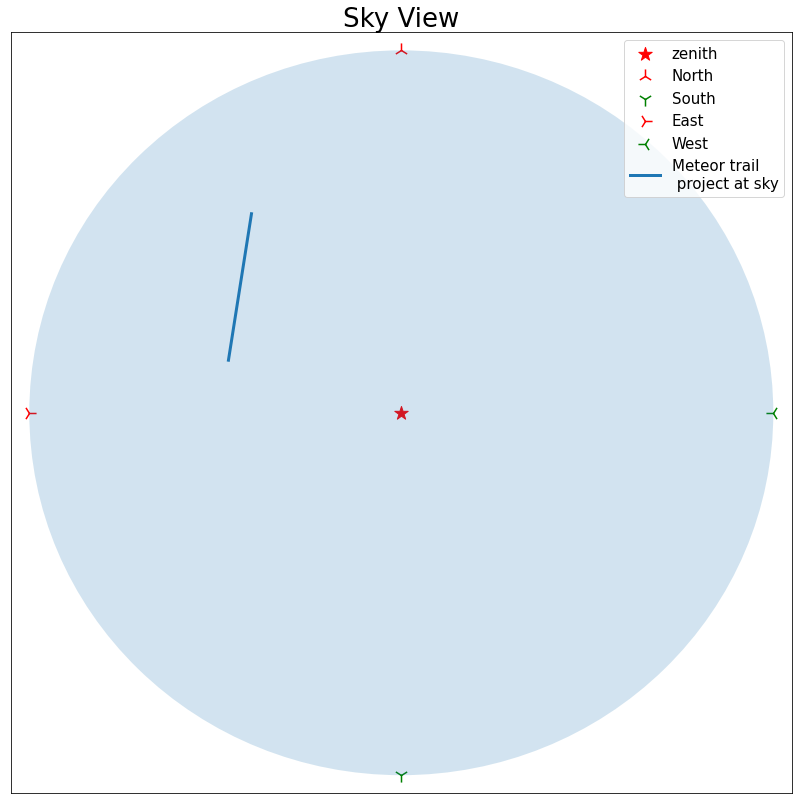

In [3]:
# 由于使用单位圆作为天球，x，y值而不是弧度表示天球上的位置，因此与真实位置有一点差异，
# 比如theta=30,phi=0应该出现在【1/3,0】的位置上，但是按照我的算法是在【1/2,0】的位置上。
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cir1 = plt.Circle(xy=(0.0,0.0),radius=1,alpha=0.2)

plt.scatter(0,0,marker="*",color="r",s=200,label="zenith")
plt.scatter(0,1,marker="2",color="r",s=200,label="North")
plt.scatter(0,-1,marker="1",color="g",s=200,label="South")
plt.scatter(-1,0,marker="4",color="r",s=200,label="East")
plt.scatter(1,0,marker="3",color="g",s=200,label="West")

#plt.scatter(y,-x,c='y',s=20,label="covered sky")
plt.plot([-mx,-Mx],[my,My],linewidth=3,label="Meteor trail\n project at sky")

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)

plt.xticks([])
plt.yticks([])

ax.add_patch(cir1)
plt.legend(fontsize=15,loc='best')
plt.title("Sky View",fontsize=26)

#file_name = "meteor_pos-xyz_"+str(op) + "-theta_phi-"+str(mt_theta)+"_"+str(mt_phi)
#plt.savefig("/home/jiomer/Documents/pygdsm/DEoRtool/meteor_fig/"+file_name+".png",dpi=200)
plt.show()

In [4]:
# 发射光线，istheta，isphi记录了可以被反射的ray的方向
# 建议先在全天用0.1的分辨率扫一遍然后用更小的范围更高的精度计算反射天区
T1 = time.time()
delang=0.01
ray_theta = np.arange(29.1,42.8,delang)
ray_phi = np.arange(17.6,53.62,delang)
lx,ly,lz = getwl(Mm,mt_origin)
print(lx,ly,lz)
ist = []
isp = []
# 被反射光线覆盖到的天区坐标
thetal = []
phil = []
for i in ray_theta:
    for j in ray_phi:
        ray = Ray(i,j)
        rv = ray.rayvectors()
        tsrv = get_trans(rv,lx,ly,lz)
        blv,nv = mt.return_nvector(tsrv,wl_origin)
        if blv == True:
            refv = reflection(tsrv,nv)
            tsrefv = get_trans(refv,lx,ly,lz,ws2wl=False)
            skytheta,skyphi = vec2ang(tsrefv[0],tsrefv[1],tsrefv[2])
            # 如果指向底面（theta大于0.5pi)就扔掉
            if skytheta < 0.5*np.pi:
                ist.append(i)
                isp.append(j)
                thetal.append(skytheta)
                phil.append(skyphi)
            else:
                pass
        else:
            pass
T2 = time.time()
print('耗费时间:%s 秒'%(T2-T1))
print(f"min theta is {min(ist)}, min phi is {min(isp)}")
print(f"max theta is {max(ist)}, max phi is {max(isp)}")
thetal = np.array(thetal)
phil = np.array(phil)

[-0.30465579 -0.7900957  -0.53191505] [ 0.88441215 -0.02736381 -0.46590383] [ 0.35355339 -0.61237244  0.70710678]
耗费时间:179.4793393611908 秒
min theta is 29.15000000000001, min phi is 17.6
max theta is 42.79000000000214, max phi is 53.610000000005634


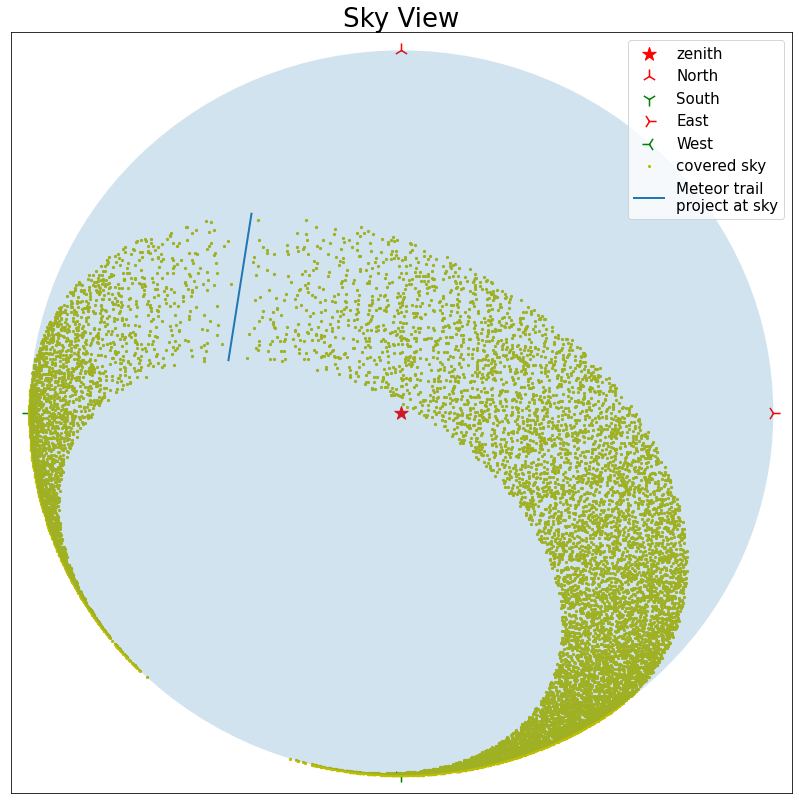

In [5]:
x = np.sin(thetal)*np.cos(phil)
y = np.sin(thetal)*np.sin(phil)
z = np.cos(thetal)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cir1 = plt.Circle(xy=(0.0,0.0),radius=1,alpha=0.2)

plt.scatter(0,0,marker="*",color="r",s=200,label="zenith")
plt.scatter(0,1,marker="2",color="r",s=200,label="North")
plt.scatter(0,-1,marker="1",color="g",s=200,label="South")
plt.scatter(1,0,marker="4",color="r",s=200,label="East")
plt.scatter(-1,0,marker="3",color="g",s=200,label="West")

plt.scatter(-x,y,c='y',s=5,label="covered sky")
plt.plot([-mx,-Mx],[my,My],linewidth=2,label="Meteor trail\nproject at sky")

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)

plt.xticks([])
plt.yticks([])

ax.add_patch(cir1)
plt.legend(fontsize=15,loc='best')
plt.title("Sky View",fontsize=26)

file_name = "meteor_pos-xyz_"+str(mt_origin) + "-theta_phi-"+str(mt_theta)+"_"+str(mt_phi)+"delta_ang-"+str(delang)
#plt.savefig("/home/jiomer/Documents/pygdsm/DEoRtool/meteor_fig/"+file_name+".png",dpi=200)
plt.show()

In [6]:
NSIDE = 2**9
res_ang= hp.nside2resol(NSIDE, arcmin=True) / 60
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, res_ang
    )
)

NPIX = hp.nside2npix(NSIDE)
print(f"NPIX is: {NPIX}.")

Approximate resolution at NSIDE 512 is 0.11 deg
NPIX is: 3145728.


origin pix is: (0.2063114679770761, -0.12823287549287937, 0.9700473740101416)
0.11024342030912239 2.300155795371307


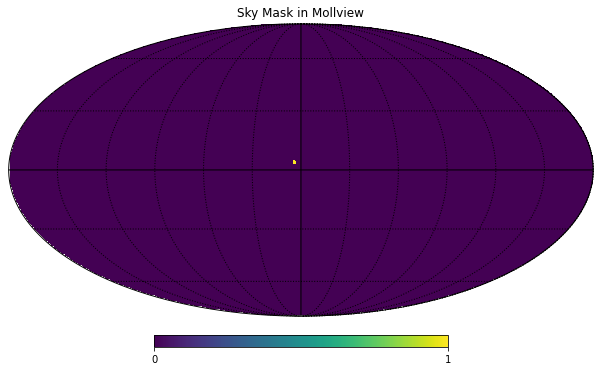

In [7]:
"""
测试位置，根据返回的像素位置信息转化为xyz坐标值然后使用MTRT中的ec2ang计算天顶距和方位角

"""

m = 0*np.ones( (1,NPIX) )[0]
positions = []
ipix_disc = hp.query_disc(nside=NSIDE, vec=np.array([z[10],x[10],y[10]]), radius=np.radians(1) )
print(f"origin pix is: {-x[0],y[0],z[0]}")
positions.extend(ipix_disc)
m[ipix_disc] = 1

positions = np.unique(positions)
theta_ql = []
phi_ql = []
for j in range(len(positions)):
    zz,xx,yy = hp.pix2vec(NSIDE, positions[j])
    tmp_theta,tmp_phi = vec2ang(-xx,yy,zz)
    theta_ql.append(tmp_theta)
    phi_ql.append(tmp_phi)
hp.mollview(m, title="Sky Mask in Mollview")
hp.graticule()
print(theta_ql[0],phi_ql[0])

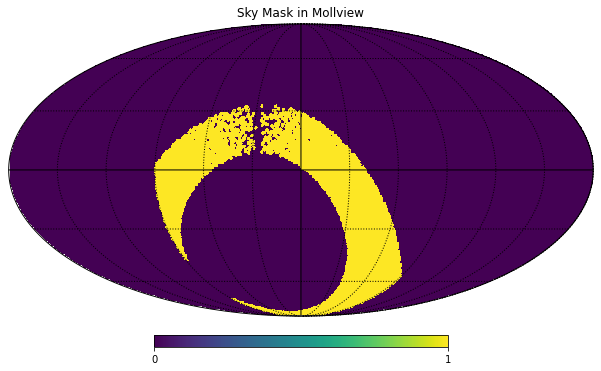

In [8]:
m = 0*np.ones( (1,NPIX) )[0]
positions = []
for i in range(len(x)):
    ipix_disc = hp.query_disc(nside=NSIDE, vec=np.array([z[i],x[i],y[i]]), radius=np.radians(1) )
    positions.extend(ipix_disc)
    m[ipix_disc] = 1

positions = np.unique(positions)
theta_ql = []
phi_ql = []
for j in range(len(positions)):
    zz,xx,yy = hp.pix2vec(NSIDE, positions[j])
    wlv = get_trans([xx,yy,zz],lx,ly,lz)
    thetaq,phiq = vec2ang(wlv[0],wlv[1],wlv[2])
    #tmp_theta,tmp_phi = vec2ang(-xx,yy,zz)

    theta_ql.append(thetaq)
    phi_ql.append(phiq)

hp.mollview(m, title="Sky Mask in Mollview")
hp.graticule()

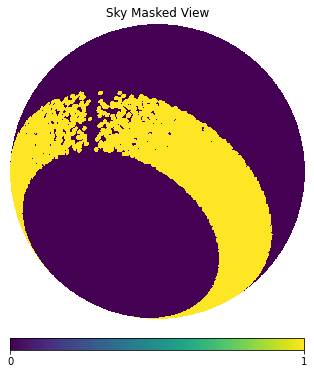

In [9]:
hp.orthview(m,half_sky=True, title="Sky Masked View")

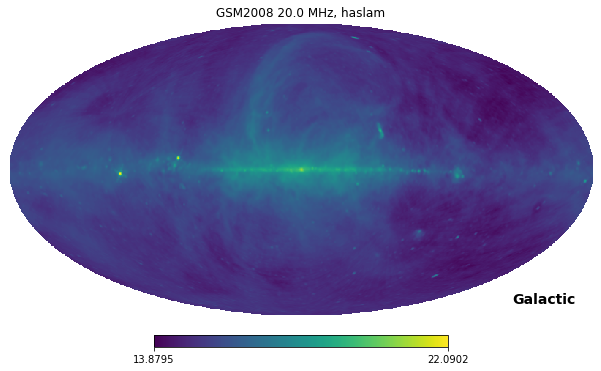

In [10]:
sky1 = LGSM()
freqs = np.arange(20,31,1)
#生成一个XXMHz的天图并查看
sky1.generate(freqs)
sky1.view(logged=True)

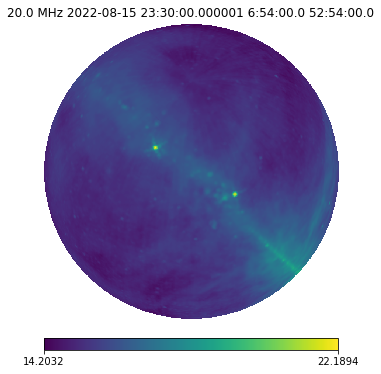

In [11]:
#设定经纬度与时间
(latitude, longitude, elevation) = ('52.9', '6.9', 100)
sky1.lon = longitude
sky1.lat = latitude
sky1.elev = elevation
sky1.date = datetime(2022, 8, 15, 23, 30)
O_sky = sky1.masks_sky()#生成一个设定观测地点时间的实际观测天图，数据为第一步时生成的
sky1.view_observed_sky(logged=True)

In [12]:
signal = []
for i in range(len(freqs)):
    signal.append(O_sky.data[i]*m)
#hp.orthview(signal[0],half_sky=True, title="Meteor trail reflected area")

## 计算天线接收的功率

#### 由notes第17页的公式推导，我们有：
### $$P_{r} = P_{t}G_{r} \frac{ \lambda^{3} }{ 4\pi\left( 2R\sin^{2}\theta_{q}(\frac{e}{r_{e}q})^{1/2}+(\frac{\lambda}{\pi})^{1/2}\sin\theta_{q}\cos\phi_{q} \right) }$$
#### 其中re是电子经典半径，R为观测点到流星尾迹中点的距离（注意在code中计算反射天区用的是流星圆柱体下底面的圆心，因此需要计算R，$\theta_{q},\phi_{q}$分别是天体在地平坐标系中的天顶距和方位角，e是自然底数。

#### 由于GSDM模型提供的数据是天体的温度$T_{b}$，因此需要将温度转换为功率，参考tools of ra。s为像素化单个像素的面积。
### $$ B_{\nu} = \frac{2k\nu^{2}}{c^{2}}T_{b} $$
### $$ P_{t} = S_{t} = B_{\nu}*s $$

#### 因为我们算的是但一频率上的功率，因此此时的功率P就相当于在这个频率上的流量。且如果optical depth很大，才有$I_{\nu} = B_{\nu}(T_{b})$. $S_{t}$ 是天体发射的流量,。


In [15]:
"""
用cell21 得到的theta ql 和 phi ql作为天体的天顶距和方位角计算反射流量
之后随时间变化的流量计算同理
"""
Prl = []
q = 1e18
re = 2.818e-15
s = 4*np.pi/NPIX
for i in range(len(freqs)):
    Pr = []
    data = signal[i]
    nv = freqs[i]*10**6
    lam = 2.998e8/nv
    for j in range(len(positions)):
        #theta,phi = hp.pix2ang(NSIDE,positions[j])
        Pt = Bv(data[positions[j]],nv/1e6)*s
        #Pt = data[positions[j]]*s*2*1.38e-23*(nv)**2/(2.998e8)**2
        sec_phiq = 1/np.cos(phi_ql[j])
        if sec_phiq < 1e-10:
            sec_phiq = 1e-10
        else:
            pass
        cof = lam**1/( 1*( 2*Mt_R*np.sin(theta_ql[j])**2*np.sqrt(np.e/(re*q))
                    + (lam*sec_phiq/(np.pi))**0.5*np.sin(theta_ql[j])*np.cos(phi_ql[j]) ) )
        #print(cof)
        Pr.append(Pt*cof)
        #print(f"theta = {theta}, phi is {phi}, cof is {cof}.")
    Prl.append(sum(Pr))

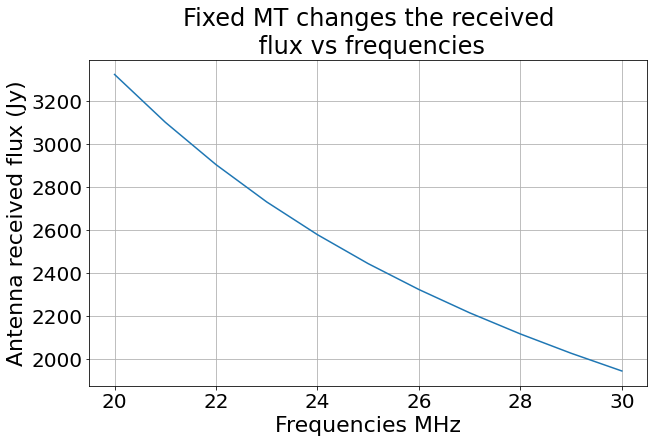

In [16]:
fig = plt.figure(figsize=(10,6))
plt.plot(freqs,np.array(Prl)/(1e-26))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title("Fixed MT changes the received\n flux vs frequencies",fontsize=24)
plt.ylabel("Antenna received flux (Jy)",fontsize=22)
plt.xlabel("Frequencies MHz",fontsize=22)

plt.grid()

#plt.savefig("/home/jiomer/Documents/pygdsm/DEoRtool/meteor_fig/"+file_name+"-fluxfreq.png",dpi=200)
plt.show()

## Antenna Temperture change with time

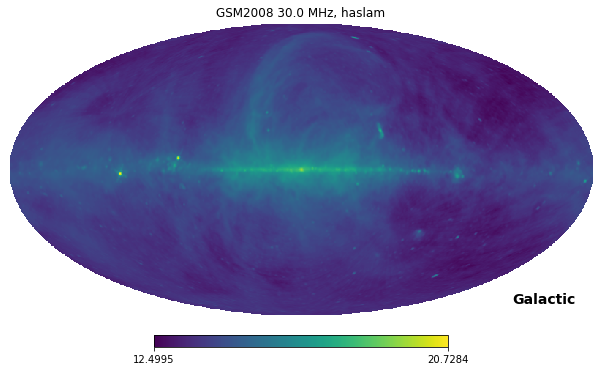

In [17]:
sky2 = LGSM()
#生成一个100MHz的天图并查看
freq = 30
lam = 3e8/(freq*10**6)
sky2.generate(freq)
sky2.view(logged=True)

In [18]:
hours = np.arange(0,24,1)
mins = np.arange(0,60,20)

#设定经纬度与时间
(latitude, longitude, elevation) = ('52.9', '6.9', 100)
sky2.lon = longitude
sky2.lat = latitude
sky2.elev = elevation


q = 1e18
re = 2.818e-15
s = 4*np.pi/NPIX
Prl = []
time_list = []
for i in hours:
    for j in mins:
        sky2.date = datetime(2022, 8, 15, i, j)
        O_sky = sky2.mask_sky()
        signal = O_sky.data*m
        time_list.append(i+j/60)
        Pr = 0
        for k in range(len(positions)):
            #gain = Gr(theta_ql[k],phi_ql[k])
            sec_phiq = 1/np.cos(phi_ql[k])
            if sec_phiq < 1e-10:
                sec_phiq = 1e-10
            else:
                pass
            Pt = Bv(signal[positions[k]],freq)*s
            cof = lam**1/( 1*( 2*Mt_R*np.sin(theta_ql[k])**2*np.sqrt(np.e/(re*q))
                    + (lam*sec_phiq/(np.pi))**0.5*np.sin(theta_ql[k])*np.cos(phi_ql[k]) ) )
            dPr = Pt*cof
            Pr = Pr + dPr
        #print(Pr)
        Prl.append(Pr)

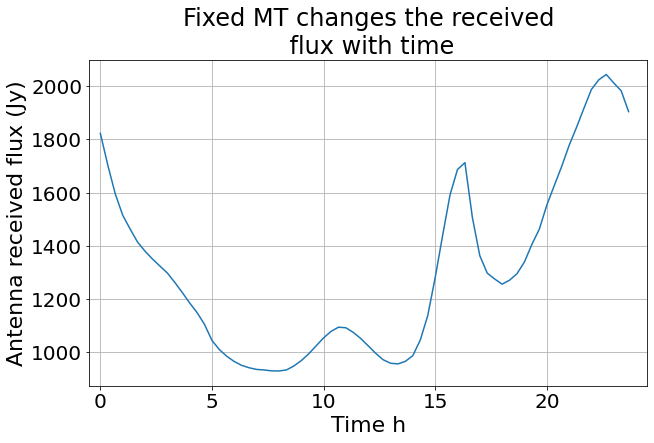

In [19]:
fig = plt.figure(figsize=(10,6))
plt.plot(time_list,np.array(Prl)/1e-26)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(-0.5,24.5)

plt.title("Fixed MT changes the received\n flux with time",fontsize=24)
plt.ylabel("Antenna received flux (Jy)",fontsize=22)
plt.xlabel("Time h",fontsize=22)

plt.grid()

#plt.savefig("/home/jiomer/Documents/pygdsm/DEoRtool/meteor_fig/"+file_name+"-fluxtime.png",dpi=200)
plt.show()